In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\School\BS Thesis\src`


In [2]:
Pkg.add("Plots")
Pkg.add("Random")

    Updating registry at `C:\Users\ioakimsy\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\School\BS Thesis\src\Project.toml`
  No Changes to `C:\School\BS Thesis\src\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\School\BS Thesis\src\Project.toml`


  No Changes to `C:\School\BS Thesis\src\Manifest.toml`


In [3]:
using Plots
using Random

In [4]:
default(aspect_ratio=:equal,
	cbar = false,
	showaxis = false,
	c = palette(:grays,rev=true),
	size = (512,512),
	yflip=true,
)

In [5]:
function initiate_grid(type::String, L::Int=8)
    # May add line to ensure that L is even.
    if L%2 == 1
        L=L+1
    end

    grid = zeros(Int,L,L)

    if type == "center"
        grid[L÷2:L÷2+1,L÷2:L÷2+1] .= 1
    elseif type == "outer_corner"
        grid[1,1] = 1
        grid[1,end] = 1
        grid[end,1] = 1
        grid[end,end] = 1 
    elseif type == "inner_corner"
        grid[L÷4,L÷4] = 1
        grid[L÷4,end-L÷4+1] = 1
        grid[end-L÷4+1,L÷4] = 1
        grid[end-L÷4+1,end-L÷4+1] = 1
    else
        error("ERROR: Not a valid initital seating arrangement type")
    end

    return grid
end

initiate_grid (generic function with 2 methods)

In [6]:
function initiate_grid_rand(num_learned::Int=4,L::Int=8)
    grid = zeros(Int,L,L)

    while sum(grid) < num_learned
        grid[rand(1:L),rand(1:L)] = 1
    end

    return grid
end

initiate_grid_rand (generic function with 3 methods)

In [ ]:
#Note: adjacency_matrix[x,y] is not necessarily adjacency_matrix[y,x]
#Note: only works for 3x3 λ's
function generate_neighbor_list(grid,λ)
    num_students = prod(size(grid))
    adjacency_matrix = zeros(num_students,num_students)

    for row in 1:size(grid)[1], col in 1:size(grid)[2]
        student = grid[row,col]

        if row==1 && col==1 #TL
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]
            adjacency_matrix[student,grid[row+1,col+1]] = λ[9]

        elseif row==1 && col==size(grid)[2] #TR
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            adjacency_matrix[student,grid[row,col-1]] = λ[2]
            adjacency_matrix[student,grid[row+1,col-1]] = λ[3]

        elseif row==size(grid)[1] && col==size(grid)[2] #BR
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row-1,col-1]] = λ[1]
            adjacency_matrix[student,grid[row,col-1]] = λ[2]

        elseif row==size(grid)[1] && col==1 #BL
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row-1,col+1]] = λ[7]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]

        elseif row==1
            adjacency_matrix[student,grid[row,col-1]] = λ[2]
            adjacency_matrix[student,grid[row+1,col-1]] = λ[3]
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]
            adjacency_matrix[student,grid[row+1,col+1]] = λ[9]
            
        elseif row==size(grid)[1]
            adjacency_matrix[student,grid[row-1,col-1]] = λ[1]
            adjacency_matrix[student,grid[row,col-1]] = λ[2]
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row-1,col+1]] = λ[7]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]
            
        elseif col==1
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            adjacency_matrix[student,grid[row-1,col+1]] = λ[7]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]
            adjacency_matrix[student,grid[row+1,col+1]] = λ[9]

        elseif col==size(grid)[2]
            adjacency_matrix[student,grid[row-1,col-1]] = λ[1]
            adjacency_matrix[student,grid[row,col-1]] = λ[2]
            adjacency_matrix[student,grid[row+1,col-1]] = λ[3]
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            
        else
            adjacency_matrix[student,grid[row-1,col-1]] = λ[1]
            adjacency_matrix[student,grid[row,col-1]] = λ[2]
            adjacency_matrix[student,grid[row+1,col-1]] = λ[3]
            adjacency_matrix[student,grid[row-1,col]] = λ[4]
            adjacency_matrix[student,grid[row+1,col]] = λ[6]
            adjacency_matrix[student,grid[row-1,col+1]] = λ[7]
            adjacency_matrix[student,grid[row,col+1]] = λ[8]
            adjacency_matrix[student,grid[row+1,col+1]] = λ[9]
        end
    end

    return adjacency_matrix
end

generate_neighbor_list (generic function with 1 method)

In [26]:
# Convolution-like solution
function generate_next_generation(initial_grid::Array{Int},λ::Array{Float64})
    grid = zeros(Int,size(initial_grid)[1]+2,size(initial_grid)[1]+2)
    grid[2:end-1,2:end-1] .= initial_grid

    next_gen = zeros(size(grid))
    for col in 2:size(initial_grid)[1]+1, row in 2:size(initial_grid)[2]+1

        if grid[row,col] == 1
            next_gen[row,col] = 1
            continue
        end

        neighborhood = grid[row-1:row+1, col-1:col+1]
        learn_prob = 1 - prod(ones(3,3) .- (neighborhood .* λ))

        random_number = rand()

        if random_number <= learn_prob
            next_gen[row,col] = 1
        end
        
    end
    return next_gen[2:end-1,2:end-1]
end

generate_next_generation (generic function with 1 method)

In [27]:
test_grid = initiate_grid("inner_corner")

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0
 0  0  0  0  0  0  0  0

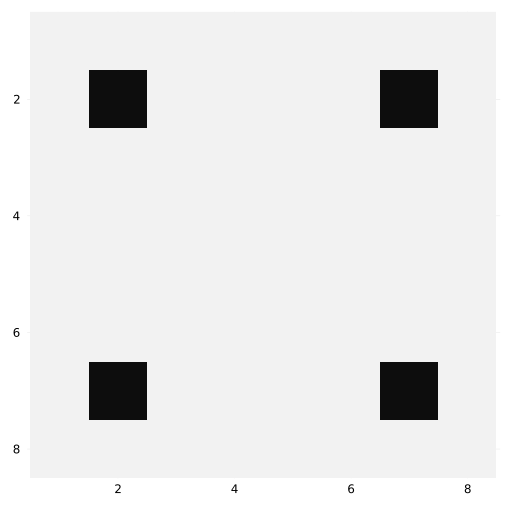

In [28]:
heatmap(test_grid)

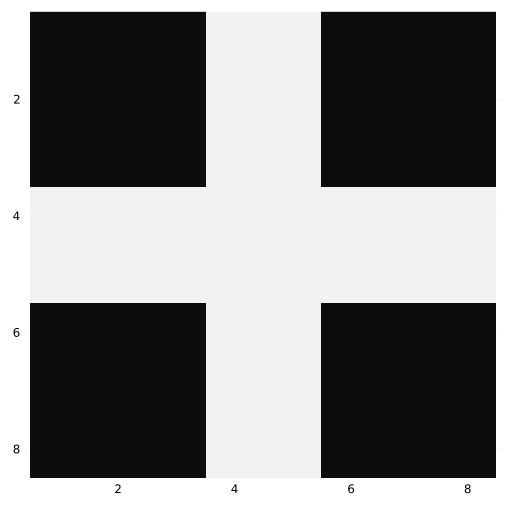

In [29]:
heatmap(generate_next_generation(test_grid,ones(3,3)))

In [59]:
adjacency_matrix[1,2]

0.5

In [57]:
λ = Matrix([1 1 1;
            1 1 1;
            1 0.5 1])
adjacency_matrix = generate_neighbor_list(reshape(1:64,8,8),λ)

64×64 Matrix{Float64}:
 0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.5  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.5  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.5  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.5  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.5     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     

1.0

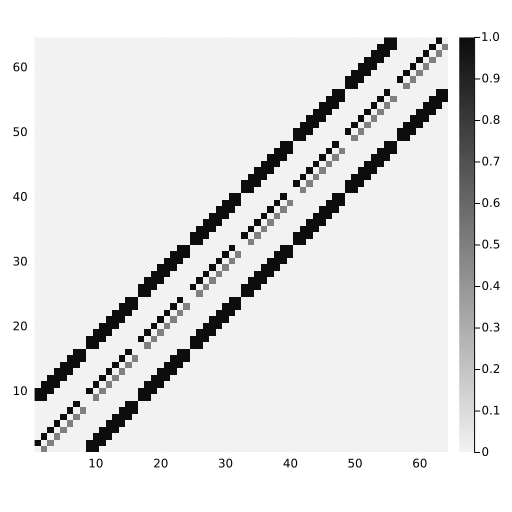

In [62]:
heatmap(adjacency_matrix, yflip=false, cbar=true, c=cgrad(:grays,rev=true))